In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn import decomposition, manifold

% matplotlib notebook

In [2]:
def compute_distance(x,y):
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    return np.linalg.norm(x-y)

In [3]:
def print_percentage(n, t):
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('=' * ((n * 20/t) + 1) , n * 100/t + 1 ))
    sys.stdout.flush()

In [4]:
#feature_dir = '/fileserver/nmec-handwriting/localfeatures/nmec_bw_cc_deNNiam_fiel657_min500'
feature_dir = '/fileserver/nmec-handwriting/localfeatures/nmec_bw_denoised_cc_deNNiam_fiel657_min500/'

files = os.listdir(feature_dir)
files.sort()

feature_map = []
for i,filename in enumerate(files):
    path = feature_dir + "/" + filename
    #if os.path.isfile(path) and ( '008.' not in filename ):
    if os.path.isfile(path):
        try:
            feature_map.append( np.load(path).mean(axis=0) )
        except:
            feature_map.append( np.ones([1,4096]) * sys.maxint)
    print_percentage(i, len(files))
        
feature_map = np.array(feature_map)
feature_map.shape

[====================] 100%

(708, 4096)

In [5]:
pca = decomposition.PCA(n_components=399)
transform = pca.fit_transform(feature_map)
transform.shape

(708, 399)

In [6]:
metric = []
for i, image in enumerate(transform):
    metricline = [np.array([compute_distance(image, other) for other in transform])]
    metric += metricline
    print_percentage(i, len(transform))

metric = np.array(metric)
F = -metric
np.fill_diagonal(F, -sys.maxint)

[====================] 100%

In [7]:
soft_correct = 0
hard_correct = 0
total_num = 0

k = 10
g = 8
max_top = 3

for j, i in enumerate(F):
    
    total_num += 1
    topk = i.argsort()[-k:]
    
    if files[j][:6] in (files[index][:6] for index in topk):
        soft_correct += 1
    
    hardsample = list(files[index][3:6] for index in topk[-max_top:])
    if len(set(hardsample)) == 1 and hardsample[0] == files[j][3:6]:
        print "%s matched %s" % (files[j][3:10], hardsample)
        hard_correct += 1

print "%-30s" % ( "-" * 37 )
print "SOFT CRITERIA: Top %d\t= %f" %(k, (soft_correct + 0.0) / total_num)
print "HARD CRITERIA: Top %d\t= %f" %(max_top, (hard_correct + 0.0) / total_num)

006-002 matched ['006', '006', '006']
006-004 matched ['006', '006', '006']
009-001 matched ['009', '009', '009']
009-004 matched ['009', '009', '009']
015-005 matched ['015', '015', '015']
015-006 matched ['015', '015', '015']
026-001 matched ['026', '026', '026']
026-003 matched ['026', '026', '026']
026-005 matched ['026', '026', '026']
026-007 matched ['026', '026', '026']
056-001 matched ['056', '056', '056']
056-004 matched ['056', '056', '056']
056-006 matched ['056', '056', '056']
056-007 matched ['056', '056', '056']
060-002 matched ['060', '060', '060']
060-003 matched ['060', '060', '060']
060-004 matched ['060', '060', '060']
060-006 matched ['060', '060', '060']
060-008 matched ['060', '060', '060']
099-001 matched ['099', '099', '099']
099-003 matched ['099', '099', '099']
-------------------------------------
SOFT CRITERIA: Top 10	= 0.459040
HARD CRITERIA: Top 3	= 0.029661


In [11]:
def run_pca_analysis(n_components, F):
    
    k = 10
    max_top = 3
    total_num = 0
    hard_correct = 0
    soft_correct = 0
    
    # create new model and fit data
    pca = decomposition.PCA(n_components=n_components)
    transform = pca.fit_transform(feature_map)
    
    # calculate distances based on new model
    metric = []
    for i, image in enumerate(transform):
        metricline = [np.array([compute_distance(image, other) for other in transform])]
        metric += metricline
        print_percentage(i, len(transform))

    metric = np.array(metric)
    F = -metric
    np.fill_diagonal(F, -sys.maxint)
    
    #get the metrics for this latest run
    for j, i in enumerate(F):        
            
        total_num += 1
        topk = i.argsort()[-k:]
        
        if files[j][:6] in (files[index][:6] for index in topk):
            soft_correct += 1
    
        hardsample = list(files[index][3:6] for index in topk[-max_top:])
        if len(set(hardsample)) == 1 and hardsample[0] == files[j][3:6]:
            hard_correct += 1
    
    return (soft_correct - 0.0) / total_num    

[====================] 100%

<IPython.core.display.Javascript object>


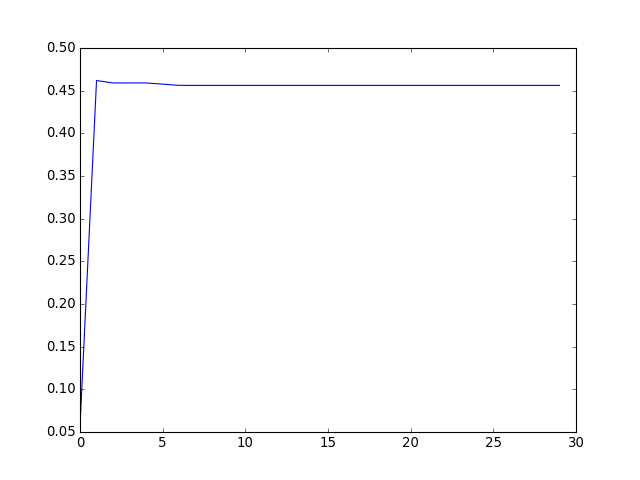

In [12]:
x = np.array([run_pca_analysis(k, F) for k in range(1, 3000, 100)], dtype=np.float32)
plt.plot(x)